<b>CUT THE ORIGINAL DATASET</b>

Student: Ludovico Frizziero 1178973

The original dataset was too big to be useful (>70GB). Here I cut it in smaller pieces, more manageable and also more meningfull. The results are serialized using the utility cPickle for Python before being saved. The same utility can deserialize them back into native Python objects.

The most relevant dataset is "Milan to Milan phone calls". Starting with this, determine which epoch to use for slicing apart datasets.

In [1]:
epochs = dict()
epoch_to_pick = 0  #just any value. The closer to 0, the more data (in the form of Graph edges, not nodes) the epoch will have. 
                    #If the value exceeds the epochs that are avaiable, it defaults to 0.

with open('L:\Milan-DandelionDataset\MItoMI-2013-11-13.txt', 'r') as f:
    for line in f:
        e = (line.split("\t"))[0]
        if e in epochs: #serch between keys
            epochs[e] = epochs[e] + 1
        else:
            epochs[e] = 1    

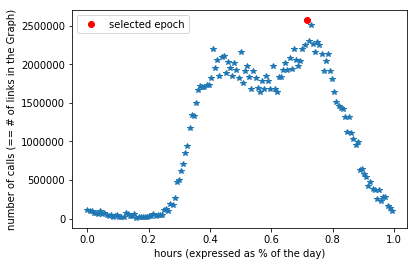

Tot epochs: 144
Epoch 1384359000000 has been selected.


In [2]:
import matplotlib.pyplot as mpl
%matplotlib inline

import operator
key_sorted_by_vals = sorted(epochs.items(), key=operator.itemgetter(1), reverse=True) #sort epochs (i.e. keys of the dict epochs) from the most occurring to the least occurring
#select an interesting epoch
if epoch_to_pick < 0 or epoch_to_pick >= len(key_sorted_by_vals):
    epoch_to_pick = 0
ep = key_sorted_by_vals[epoch_to_pick][0]

mpl.figure()
base = min([int(x) for x in epochs.keys()])
ms = 1000*60*60*24 #milliseconds in a day
mpl.plot([(float(x)-base)/ms for x in epochs.keys()],epochs.values() , "*",)
mpl.plot((float(ep)-base)/ms, epochs[ep], "ro", label="selected epoch")
mpl.ylabel("number of calls (== # of links in the Graph)")
mpl.xlabel("hours (expressed as % of the day)")
mpl.legend()
mpl.show()

print "Tot epochs:", len(key_sorted_by_vals)

print "Epoch", ep, "has been selected."

In [5]:
import networkx as nx
import cPickle as cp #data serialization for Python

#cut the file to include only data from the selected epoch
count = 0
written = 0
tot = sum(epochs.values())

#Do weights must be saved as well or not? The size of the pickle file doubles if weights are saved
save_w = False

G = nx.DiGraph() #Directed and weighted graph
edges = []
with open('L:\Milan-DandelionDataset\MItoMI-2013-11-13.txt', 'r') as f:
    for line in f:
        splitted = line.split("\t")
        if splitted[0] == ep:
            if save_w:
                edges.append((int(splitted[1]), int(splitted[2]) float(splitted[3])))
            else:
                edges.append((int(splitted[1]), int(splitted[2])))
            written = written + 1
        else:
            count = count + 1
            
if save_w:
    G.add_weighted_edges_from(edges)
else:
    G.add_edges_from(edges) #Create and save the Graph
    
name = 'DATA\MItoMI_2013-11-13_'+str(ep)+'_Graph.pkl'
with open(name, 'wb') as out:
    cp.dump(G, out)
    
print "Graph has", len(G), "nodes."
print 'All done ->' + " ok? " + str(written == epochs[ep])+ " " +  str(tot)  + " " + str(count) + " " +  str(tot-count)        

Graph has 9986 nodes.
All done -> ok? True 158158045 155588643 2569402


Now cut "Mi to Provinces" dataset:

In [4]:
tmp = []
with open('L:\Milan-DandelionDataset\mi-to-provinces-2013-11-13.txt', 'r') as f:
    for line in f:
        tokens = line.split("\t")
        if tokens[2] == ep:
              tmp.append(tokens)
    
#tokens[0] = square id
#tokens[1] = province name
#tokens[2] = epoch
#tokens[3] = square to province link weight (can be NULL only if tokens[4] will be not)
#tokens[4] = province to square link weight (can be NULL only if tokens[3] was not)

prov_names = set()
for x in tmp:
    prov_names.add(x[1])
prov_names = sorted(prov_names)
prov_IDs = range(110000, 110000+len(prov_names)) #provinces IDs start with 11
pIDs = dict(zip(prov_names, prov_IDs))


edges = []
for t in tmp:
    try:
        edges.append( (int(t[0]), pIDs[t[1]], float(t[3])) )
    except ValueError:
        pass
        #print t
    try:
        edges.append( (pIDs[t[1]], int(t[0]), float(t[4])) )   
    except ValueError:
        pass
        #print t
        
P = nx.DiGraph()       
P.add_weighted_edges_from(edges)
print 'Graph has', len(P), 'nodes, out of which', len(pIDs.keys()), 'are provinces.'
name = 'DATA\MItoProv_2013-11-13_'+str(ep)+'_Graph.pkl'
with open(name, 'wb') as out:
    cp.dump(P, out)
with open(name.replace('_Graph.pkl', '_provIDs.pkl'), 'wb') as out:
    cp.dump(pIDs, out)

Graph has 10104 nodes, out of which 109 are provinces.


And finally cut "Sms, calls and internet" dataset:

In [5]:
tmp = []
with open('L:\Milan-DandelionDataset\sms-call-internet-mi-2013-11-13.txt', 'r') as f:
    for line in f:
        tokens = line.split("\t")
        if tokens[1] == ep:
            tmp.append(tokens)
            
#tokens[0] = square id
#tokens[1] = epoch
#tokens[2] = country code
#tokens[5] = square to country link weight (can be NULL independently of tokens[6])
#tokens[6] = country to square link weight (can be NULL independently of tokens[5])

edges = []
countries = set()
for t in tmp:
    if not int(t[2]) == 0: #this means that only SMS data are avaiable, we don't need them though 
        countries.add(t[2]) 
        c = 1200000 + int(t[2]) # add an offset to distinguish country's codes from regular nodes and province's IDs
        try:
            edges.append( (c, int(t[2]), float(t[5])) )
        except ValueError:
            pass
            #print t
        try:
            edges.append( (c, int(t[0]), float(t[6])) )   
        except ValueError:
            pass
            #print t

S = nx.DiGraph()
S.add_weighted_edges_from(edges)
print 'Graph has', len(S), 'nodes, out of which', len(countries), 'are countries.'
name = 'DATA\SMS_2013-11-13_'+str(ep)+'_Graph.pkl'
with open(name, 'wb') as out:
    cp.dump(S, out)

Graph has 10081 nodes, out of which 108 are countries.
